In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets, interactive, IntSlider
import requests
import time
from termcolor import colored
import matplotlib.pylab as pl

In [2]:
#Loading of dataset
data_raw=pd.read_csv('data_with_new_variables.csv')
data_original=pd.read_csv('dataset_6.csv')

In [65]:
for column in data_original.columns:
    data_original[column].fillna(data_original[column].mode()[0], inplace=True)
data_original['building_floor'].unique()
replace_floor={'1 to 4':1,'5 to 9':2, '10 or above':3 }
data_original=data_original.replace(replace_floor)

In [66]:
import pandas as pd
import matplotlib.pyplot as plt,mpld3
import numpy as np
from ipywidgets import widgets, interactive, IntSlider,interact_manual
import requests
import time
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
import plotly
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,r2_score, accuracy_score, confusion_matrix
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
import statsmodels.api as sm
from xgboost.sklearn import XGBClassifier

## Creating widget that are needed for the analysis

In [67]:
column_list=list(data_original.columns)
column_list.remove('survey_id')
style = {'description_width': 'initial','handle_color' : 'lightblue'}
building_name=widgets.Dropdown(
    options=['All','A', 'B', 'C'],
    value='All',
    description='Building: ',
)
age_range = widgets.Dropdown(
    options=['All','20 or below', '21 - 30', '31 - 40', '41 - 50','51 or above'],
    value='All',
    description='Age Range: ',
)
gender=widgets.ToggleButtons(
    options=["All", 'Male', 'Female'],
    description='Gender : ',
    value='All',
    disabled=False,
    button_style='info', 
)
outcome_var = widgets.Dropdown(
    options=column_list,
    value='workspace_rating',
    description='Outcome Variable : ',
    style=style
)
independent_var=widgets.SelectMultiple(
    options=column_list,
    description='Independent Variable: ',
    value=['temperature_alter_ability'],
    disabled=False,
    style=style
)
workspace_tenure=widgets.Dropdown(
    options=['All','Less than 1 year', '1-5 years', '5+ years'],
    value='All',
    description='Workspace tenure: ',
    style=style
)
window_distance=widgets.Dropdown(
    options=['All','0-5 feet', '6-10 feet', '11-15 feet', '16 feet or more'],
    value='All',
    description='Window Distance: ',
    style=style
)
# analysis_model=widgets.Dropdown(
#     options=['Linear Regression','XGboost'],
#     value='Linear Regression',
#     description='Method : ',
#     style=style
# )
algorithms={'Linear Regression':['coefficients'],'XGboost':['Importance plot','SHAP Summary plot','SHAP Dependence plot' ]
            ,'Random Forest':['Importance plot']}
dependices={'coefficients':['All'],'Summary plot':['All'], 'Dependence plot':independent_var.value}
def select_parameters(method):
    parameters.options = algorithms[method]
def dependence_plot_var(parameters):
    dependence_plot.options=dependices[parameters]
method = widgets.Dropdown(options=algorithms.keys(), description='Model')
init = method.value
parameters = widgets.ToggleButtons(options=algorithms[init],
                                   description='parameters', 
                                   button_style='info')
init_2=parameters.value
dependence_plot=widgets.Dropdown(options=dependices[init_2], 
                                 description="variable")
parameters_2 = widgets.interactive(select_parameters, method=method)
dependence_plot_2=widgets.interactive(dependence_plot_var, parameters=parameters)

from ipywidgets import GridspecLayout

from ipywidgets import TwoByTwoLayout

app=TwoByTwoLayout(top_left=building_name,
               top_right=age_range,
               bottom_left=gender,
               bottom_right=outcome_var)
ui = widgets.HBox([building_name, age_range, gender,outcome_var, independent_var,
                   method, parameters,dependence_plot ])

grid_button = widgets.ToggleButton(
    value=False,
    description='Show results',
    icon='check'
)

## Below creates a grid of widgets

In [68]:
grid = GridspecLayout(3, 3, height='300px')
grid[0, 0] = building_name
grid[0, 1] = age_range
grid[0, 2] = gender
grid[1,0]=workspace_tenure
grid[1,1]=window_distance
grid[1, 2] = outcome_var
grid[2,0] = independent_var
grid[2, 1] = method
grid[2, 2] = parameters


## Build the model based on the user input

In [69]:

def apply_methods(building_name, age_range,gender,workspace_tenure,window_distance, outcome_var,independent_var, method, parameters):
    data_3=data_original.copy()
    data_3=data_3.drop(columns=['survey_id'])
    data_3=data_3.replace({'Yes':1, 'No':0})
    #data_building=data_3.copy()
    if building_name=='All':
        data_building=data_3.copy()
    elif building_name=='A':
        data_building=data_3[data_3['building_name']=='A']
    elif building_name=='B':
        data_building=data_3[data_3['building_name']=='B']
    elif building_name=='C':
        data_building=data_3[data_3['building_name']=='C']
    if gender=='All':
        data_gender=data_building.copy()
    elif gender=='Male':
        data_gender=data_building[data_building['gender']=='Male']
    elif gender=='Female':
        data_gender=data_building[data_building['gender']=='Female']
        
    if workspace_tenure=='All':
        data_tenure=data_gender.copy()
    elif workspace_tenure=='Less than 1 year':
        data_tenure=data_gender[data_gender['workspace_tenure']==1]
    elif workspace_tenure=='1-5 years':
        data_tenure=data_gender[data_gender['workspace_tenure']==2]
    elif workspace_tenure=='5+ years':
        data_tenure=data_gender[data_gender['workspace_tenure']==3]
        
    if window_distance=='All':
        data_window=data_tenure.copy()
    elif window_distance=='0-5 feet':
        data_window=data_tenure[data_tenure['window_distance']==1]
    elif window_distance=='6-10 feet':
        data_window=data_tenure[data_tenure['window_distance']==2]
    elif window_distance=='11-15 feet':
        data_window=data_tenure[data_tenure['window_distance']==3] 
    elif window_distance=='16 feet or more':
        data_window=data_tenure[data_tenure['window_distance']==4]
    
    if age_range=='All':
        data_age=data_window.copy()
    elif age_range=='20 or below':
        data_age=data_window[data_window['age_range']==1]
    elif age_range=='21 - 30':
        data_age=data_window[data_window['age_range']==2]
    elif age_range=='31 - 40':
        data_age=data_window[data_window['age_range']==3]
    elif age_range=='41 - 50':
        data_age=data_window[data_window['age_range']==4]
    elif age_range=='51 or above':
        data_age=data_window[data_window['age_range']==5]
    #correlation Matrix Heat map
    
        
    #data_age=data_age.dropna()    
    #data_age['thermal_condition']=(data_age['thermal_condition']>=3)*1
    #data_age['workspace_rating']=(data_age['workspace_rating']>=3)*1
    all_variables= list(independent_var) + [outcome_var]
    data_age=data_age[all_variables]
    corr = data_age.corr()
    ax = sns.heatmap(
                    corr, 
                    vmin=-1, vmax=1, center=0,
                    cmap=sns.diverging_palette(20, 220, n=200),
                    square=True
                )
    ax.set_xticklabels(
                    ax.get_xticklabels(),
                    rotation=45,
                    horizontalalignment='right'
                );
    data_age=data_age.dropna()
    for i in data_age.columns:
        if data_age[i].dtypes=='int64' or data_age[i].dtypes=='float64':
            data_age[i]=data_age[i].astype('category')
    percentage_of_total=round((data_age.shape[0]/data_original.shape[0])*100,2)
    print("Building selected: "+ building_name )
    print("Age group selected: "+ age_range)
    print("Gender selected: "+ gender)
    print("Total number of records: " + str(data_age.shape[0]) +" ( " + str(percentage_of_total) +"% )")
    print("--------------------------------------------------------")
    if len(data_age)!=0:
        lr=LinearRegression()
        X=data_age[list(independent_var)]
        y=data_age[[outcome_var]]
        non_int_var=0
        non_int_var_list=[]
        for i in list(independent_var):
            a=X[i].dtypes
            if a != 'category':
                non_int_var=non_int_var+1
                non_int_var_list.append(i)
        dependent_int = [x for x in list(independent_var) if x not in non_int_var_list]
        print("Outcome variable selected: "+ str(outcome_var) )
        print("--------------------------------------------------------")
        print("Number of dependent variables selected: "+ str(len(independent_var)))
        
        print("Dependent variables selected: " + str(independent_var))
        print("--------------------------------------------------------")
        #print("Number of non numeric variables selected: " + str(non_int_var))
        print("Invalid dependent variables selected: "+ str(non_int_var_list))
        print("--------------------------------------------------------")
        if non_int_var!=0 :
            print(colored("Not valid: Selcted algoritham won't work for these variables.Check the data type of the selected variables ",'red'))
        elif non_int_var==0:
            print("Selected model: " +method )
            print("Selected model: " +parameters )
            print("-----------------------------------------")
            if method=='Linear Regression':
                #Linear regression using sklearn
#                 lr=lr.fit(X,y)
#                 i=1
#                 while i<=len(independent_var):
#                     print(colored("Coefficient of " + independent_var[i-1] +" : "+  str(round((lr.coef_[0][i-1]),4)), 'green'))
#                     i += 1
                #Linear regression model using Statsmodel
                X=sm.add_constant(X)
                model=sm.OLS(y.astype(float),X.astype(float)).fit()
                print(model.summary())
            elif method=='XGboost':
                for i in X.columns:
                    X[i]=X[i].astype('int64')
                for i in y.columns:
                    y[i]=y[i].astype('int64')
                xgb_full = xgboost.DMatrix(X, label=y)
                data_dmatrix = xgboost.DMatrix(data=X,label=y)
                # create a train/test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
                xgb_train = xgboost.DMatrix(X_train, label=y_train)
                xgb_test = xgboost.DMatrix(X_test, label=y_test)
                # Creating XGBClassifier with parameters.
                xgb1 = XGBClassifier(
                             learning_rate =0.1,
                             n_estimators=1000,
                             max_depth=5,
                             min_child_weight=1,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)
                #train model on the full data set
                xgb1.fit(X,y)
                if parameters=='Importance plot':
                    
                    preds = xgb1.predict(X_test)
                    rmse = np.sqrt(mean_squared_error(y_test, preds))
                    print("RMSE: %f" % (rmse))
                    y_pred = [round(value) for value in preds]
                    accuracy = accuracy_score(y_test, y_pred)
                    print("Accuracy: %.2f%%" % (accuracy * 100.0))
#                     model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)
                    xgboost.plot_importance(xgb1,max_num_features=10)
                    pl.title("xgboost.plot_importance(model)")
                    xgboost.plot_importance(xgb1,importance_type='cover',max_num_features=10)
                    pl.title("xgboost.plot_importance(model) Importance type='cover'")
                    xgboost.plot_importance(xgb1,importance_type='gain',max_num_features=10)
                    pl.title("xgboost.plot_importance(model)Importance type='gain'")
                    pl.show()
                    
#                     data = confusion_matrix(y_test, preds)
#                     df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
#                     df_cm.index.name = 'Actual'
#                     df_cm.columns.name = 'Predicted'
#                     plt.figure(figsize = (15,10))
#                     sns.set(font_scale=1.4)#for label size
#                     sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
#                     plt.title('Confusion matrix for XGboost')
                elif parameters=='SHAP Summary plot':
                    #model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)
                    shap_values = shap.TreeExplainer(xgb1).shap_values(X)
                    #shap.summary_plot(shap_values, X)
                    shap.summary_plot(shap_values, X, plot_type="bar")
#                     for p in ax1.patches: 
#                         ax1.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
                     #print(shap_values)
                elif parameters=='SHAP Dependence plot':
                    #model = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)
                    shap_values = shap.TreeExplainer(xgb1).shap_values(X)
                    for name in X.columns:
                        shap.dependence_plot(name, shap_values, X, display_features=X)
#                 y_pred = model.predict(X_test)
#                 predictions = [round(value) for value in y_pred]
#                 # evaluate predictions
#                 accuracy = accuracy_score(y_test, predictions)
                #print("Accuracy: %.2f%%" % (accuracy * 100.0))
#                 y_pred = model.predict(X_test)
#                 rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#                 print("RMSE: %f" % (rmse))
#                 y_pred = [round(value) for value in y_pred]
#                 accuracy = accuracy_score(y_test, y_pred)
#                 print("Accuracy: %.2f%%" % (accuracy * 100.0))
                
                
                
            elif method=='Random Forest':
                RSEED = 50
                model_rf = RandomForestClassifier(n_estimators=100, 
                               random_state=RSEED, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

                    # Fit on training data
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
                model_rf.fit(X, y)
                n_nodes = []
                max_depths = []
                y_pred = model_rf.predict(X_test)
                predictions = [round(value) for value in y_pred]
                # evaluate predictions
                accuracy = accuracy_score(y_test, predictions)
                print("Accuracy: %.2f%%" % (accuracy * 100.0))
                # Stats about the trees in random forest
                for ind_tree in model_rf.estimators_:
                    n_nodes.append(ind_tree.tree_.node_count)
                    max_depths.append(ind_tree.tree_.max_depth)

                print(f'Average number of nodes {int(np.mean(n_nodes))}')
                print(f'Average maximum depth {int(np.mean(max_depths))}')
            # Extract feature importances
                fi = pd.DataFrame({'feature': list(X.columns),
                                   'importance': model_rf.feature_importances_})
                fi=fi.sort_values(by='importance', ascending=False)                    

            # Display
                fig = plt.figure(figsize=(20, 10))
    
                ax = fig.add_subplot()
                ax.bar(fi['feature'],fi['importance'])
                ax.set_xlabel('Features',fontsize=25)
                ax.tick_params(axis='y', labelsize=18)
                ax.tick_params(axis='x', labelsize=16)
                plt.title("Variable Importance plot using Random forest classifier",fontsize=22)
                plt.xticks(rotation=90)
#             xgb_train = xgboost.DMatrix(X_train, label=y_train)
#             xgb_test = xgboost.DMatrix(X_test, label=y_test)
    else:
        print("There are no data points available for the option you selected")
    
    

## Combining the function and widgets

GridspecLayout(children=(Dropdown(description='Building: ', layout=Layout(grid_area='widget001'), options=('Al…

Output()

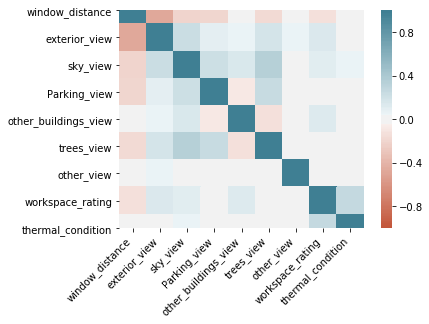

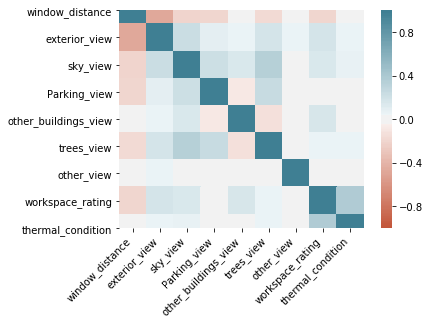

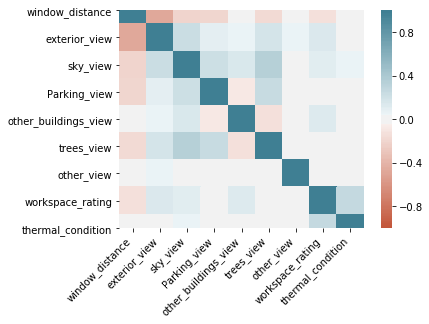

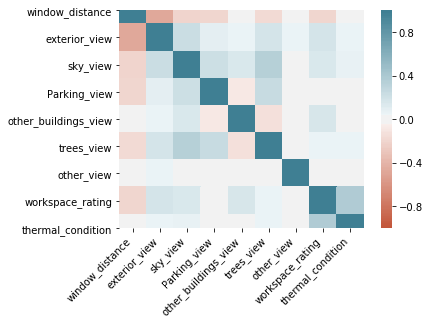

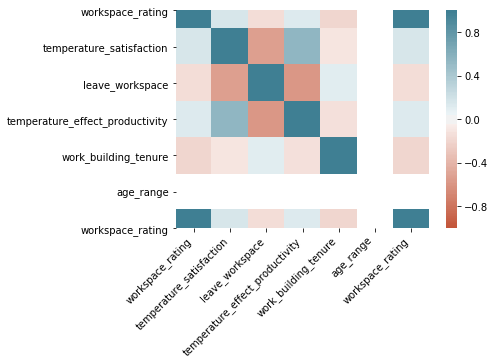

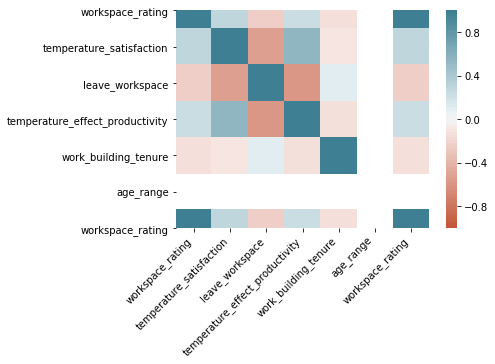

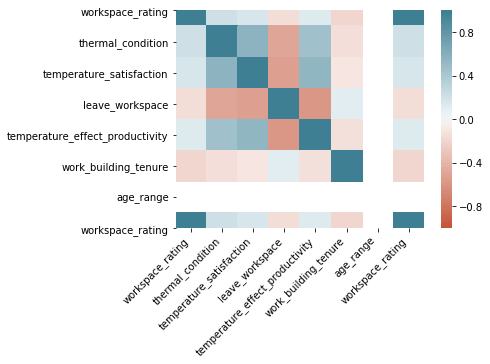

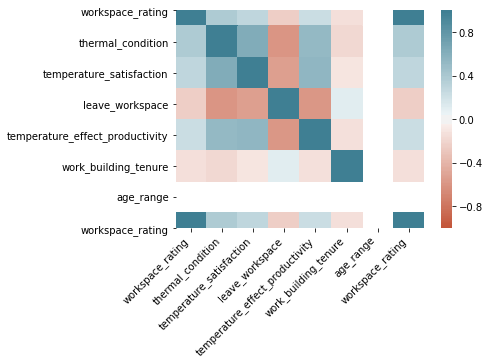

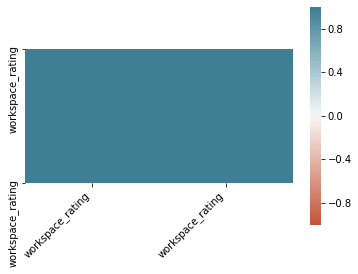

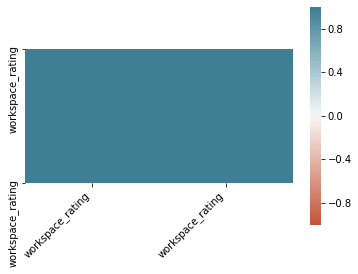

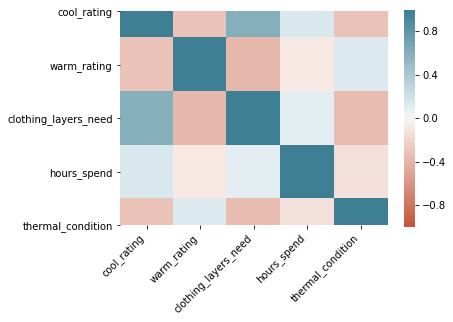

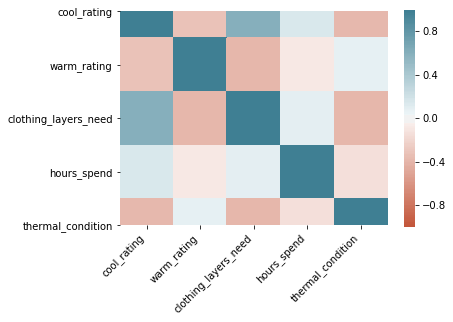

In [63]:
out = widgets.interactive_output(apply_methods, {'building_name':building_name, 'age_range':age_range, 'gender':gender,
            'workspace_tenure':workspace_tenure ,'window_distance':window_distance ,'outcome_var':outcome_var, 'independent_var':independent_var, 'method':method,
            'parameters':parameters})
out.manual = True
display(grid, out)


## Widgets for descriptive statistics

In [ ]:
column_list=list(data_original.columns)
column_list.remove('survey_id')
style = {'description_width': 'initial','handle_color' : 'lightblue'}
building_name_1=widgets.Dropdown(
    options=['All','A', 'B', 'C'],
    value='All',
    description='Building: ',
)
age_range_1= widgets.Dropdown(
    options=['All','20 or below', '21 - 30', '31 - 40', '41 - 50','51 or above'],
    value='All',
    description='Age Range: ',
)
gender_1=widgets.ToggleButtons(
    options=["All", 'Male', 'Female'],
    description='Gender : ',
    value='All',
    disabled=False,
    button_style='info', 
)
analysis_type= widgets.Dropdown(
    options=['count plot','linear regression'],
    value='count plot',
    description='Analysis Type: ',
    style=style
)
x_axis= widgets.Dropdown(
    options=column_list,
    value='thermal_condition',
    description='X Axis: ',
    style=style
)
relation=widgets.Dropdown(
    options=['None'] + column_list,
    value='None',
    description='Relation variable: ',
    style=style
)

## Count plots for the selections made thorugh widgets

In [ ]:
def analysis(building_name, age_range,gender, x_axis,relation ):
    data_4=data_original.copy()
    #data_4=data_4.dropna()
    #data_building=data_3.copy()
    if building_name=='All':
        data_building=data_4.copy()
    elif building_name=='A':
        data_building=data_4[data_4['building_name']=='A']
    elif building_name=='B':
        data_building=data_4[data_4['building_name']=='B']
    elif building_name=='C':
        data_building=data_4[data_4['building_name']=='C']
    if gender=='All':
        data_gender=data_building.copy()
    elif gender=='Male':
        data_gender=data_building[data_building['gender']=='Male']
    elif gender=='Female':
        data_gender=data_building[data_building['gender']=='Female']
    if age_range=='All':
        data_age=data_gender.copy()
    elif age_range=='20 or below':
        data_age=data_gender[data_gender['age_range']==1]
    elif age_range=='21 - 30':
        data_age=data_gender[data_gender['age_range']==2]
    elif age_range=='31 - 40':
        data_age=data_gender[data_gender['age_range']==3]
    elif age_range=='41 - 50':
        data_age=data_gender[data_gender['age_range']==4]
    elif age_range=='51 or above':
        data_age=data_gender[data_gender['age_range']==5]
    percentage_of_total=round((data_age.shape[0]/data_building.shape[0])*100,2)
    print(colored("Total number of records: " + str(data_age.shape[0]) +" ( " + str(percentage_of_total) +"% )",'green'))
    plt.figure(figsize=(10,5))
    if relation!='None':
        ax = sns.countplot(x=x_axis, hue=relation, data=data_age)
    else:
        ax = sns.countplot(x=x_axis, data=data_age)
    # ax.set_title('Thermal condition')
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=0), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')



## Now combining the funtion and widget for count plots

In [ ]:
interactive(analysis,building_name=building_name_1, age_range=age_range_1, gender=gender_1,
            x_axis=x_axis, relation=relation )